# Week 2

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats 
from pandas_datareader import data 
from datetime import datetime

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
import edhec_risk_kit as erk

In [4]:
# using seaborn style (type plt.style.available to see available styles)
plt.style.use("seaborn-dark")

## Modern portfolio theory (MPT)

The **Modern portfolio theory (MPT)** is a mathematical framework **for assembling a portfolio of assets such that the expected return is maximized for a given level of volatility**. It is a formalization of **diversification in investing**, i.e., the idea that owning different kinds of financial assets is less risky than owning only one type. 

### Efficient Frontiers 

In the MPT, The **efficient frontier** is an a curve which occupies the *efficient* part of the **volatility-return** plane. 
Formally, it is the set of portfolios which satisfy the condition that no other portfolio exists with a higher expected 
return but with the same standard deviation of return. 

The efficient frontier was first formulated by **Harry Markowitz** (1952).

### How it works
We have to construct a portfolio of several assets and **we want to find the optimal percentage of investments to be allocated in these assets** so that the overall (expected) return of such a portfolio is maximixed for a given level of volatility. 

Hence, suppose that **we have $k > 1$ assets**, and we decide to invest all of our capital in these assets. 

Let $\mathbf{w}:=(w_1,\dots,w_K)^T$, with $w_i\in (0,1)$ for all $i=1,\dots,K$, 
be the percentages of investment our portfolio, i.e, $w_i$ is the proportion of investiment in asset $i$. 
There holds $\sum_{i=1}^K w_i = 1$. 

Let $R_i$ and $R_p$ be the return of asset $i$ and the total return of the portfolio, respectively. 
Likewise, let $\sigma_i$ and $\sigma_p$ be the volatility of asset $i$ and the volatility of the portfolio, respectively. 


#### Return of a portfolio
The **total return of the porfolio** is going to be a simple weigthed sum of the (total) returns of single assets, i.e.,
$$
R_p = \sum_{i=1}^K w_i R_i = \mathbf{w}^T \mathbf{R},
$$
where $\mathbf{R} := (R_1,\dots,R_K)^T$.


#### Volatility of a portfolio
The **volatility of the porfolio** is computed as the (square root of the) variance of the weigthed sum of the returns of single assets. 

Let us make and axample with only two assets. We have $w_1$ and $w_2$ and two assets whose returns are $R_1$ and $R_2$. We have:
$$
\sigma_p^2 =   \text{Var}(w_1 R_1 + w_2 R_2) = 
w_1^2 \text{Var}(R_1) + w_2^2\text{Var}(R_2) + 2w_1 w_2\text{cov}(R_1,R_2) =
w_1^2 \sigma_1^2 + w_2^2\sigma_2^2 + 2w_1 w_2\text{cov}(R_1,R_2), 
$$
where 
$$
\text{cov}(R_1,R_2) := \mathbb{E}[(R_i-\mu_i)(R_j - \mu_j)], 
$$
is the **covariance** between asset $i$ and $j$ and where $\mu_i$ and $\mu_j$ denote 
the mean returns of assets $i$ and $j$, respectively. In particular, if we let 
$$
\rho_{ij} := \frac{\text{cov}(R_i,R_j)}{\sigma_i \sigma_j} = \frac{\text{cov}(i,j)}{\sigma_i \sigma_j}, 
$$
denote the **correlation coefficient** between assets $i$ and asset $j$, then the volatilityt of a $2$ assets portfolio becomes:
$$
\sigma_p = 
\sqrt{ w_i^2 \sigma_1^2 + w_2^2 \sigma_2^2 + 2w_1 w_2 \sigma_1 \sigma_2 \rho_{ij} }. 
$$


Now, in case of $K$ assets, we can express the volatility as follows. 
Let $\Sigma$ be the **covariance matrix**, that is, a symmetric square $K\times K$ matrix, $\Sigma = [\sigma_{ij}]$, 
where each element $\sigma_{ij} := \sigma_i \sigma_j \rho_{ij}$ ($i,j=1,\dots,K$) denote the **covariance** between assets $i$ and asset $j$, 
where $\sigma_i$, $\sigma_j$, and $\rho_{ij}$ denote the volatility and the correlation coefficient of assets $i$ and $j$, respectively. 
If $i=j$, $\sigma_{ii}=\sigma_i^2$ is simply the variance of asset $i$ (**diagonal entries are simply the variances**).

The resulting volatility is then given by:
$$
\sigma_p = \sqrt{ \mathbf{w}^T \Sigma \mathbf{w} }
$$


#### Efficient frontiers of two assets with different correlation
In the following we do a very artificial example in order to see the curve that is drawn by different portfolios which 
are constructed with only $2$ assets with different correalation $\rho_{12}$. 
First of all, we assume to generate $500$ daily returns of $2$ assets:

In [11]:
nret             = 500
periods_per_year = 252
risk_free_rate   = 0.0

Then, we set up a value for the means and the volatility of our two artifical assets:

In [12]:
mean_1 = 0.001019
mean_2 = 0.001249
vol_1  = 0.016317
vol_2  = 0.019129

and we set up the $6$ correlations of the two assets, and for every fixed correlation, 
we will generate $20$ portfolios by allocating $20$ pairs of weights:

In [13]:
# Correlation goes from 1 (completely correlated) to -1 (conversely correlated)
rhos  = np.linspace(1,-1,num=6) 
ncorr = len(rhos)

# Pairs of weights to be used to construct the portfolios for any given correlation
nweig = 20
w1 = np.linspace(0,1,num=nweig)
w2 = 1 - np.linspace(0,1,num=nweig)
ww = pd.DataFrame( [w1, w2] ).T  

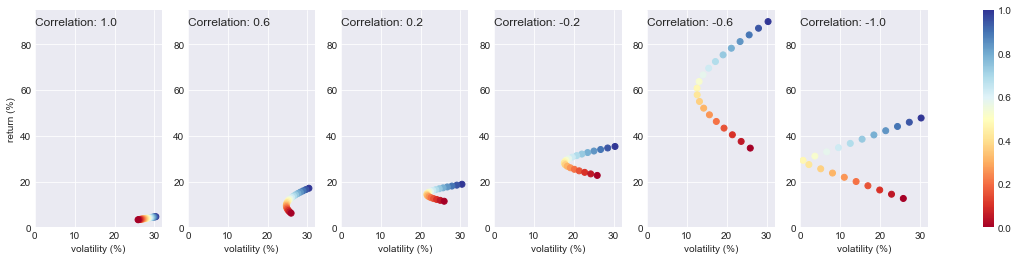

In [21]:
# Set seed
np.random.seed(1)

# Open the figure
fig, ax = plt.subplots(1,6, figsize=(20,4))    
ax = ax.flatten()

for k_rho, rho in enumerate(rhos):
    # Allocate an empty portfolio 
    portfolio = pd.DataFrame(columns=["return","volatility","sharpe ratio"])

    # Generate the assets' returns with the given correlation rho
    cov_ij     = rho * vol_1 * vol_2
    cov_rets   = pd.DataFrame( [[vol_1**2, cov_ij], [cov_ij, vol_2**2]] )
    daily_rets = pd.DataFrame( np.random.multivariate_normal((mean_1,mean_2), cov_rets.values, nret) )
    
    for i in range(ww.shape[0]):
        # Now, construct the portfolio of two asset with correlation rho and weights ww.loc[i]
        weights = ww.loc[i]

        # portfolio returns, volatility, and sharpe ratio
        ann_rets      = erk.annualize_rets(daily_rets, periods_per_year)
        portfolio_ret = np.dot(weights, ann_rets)
        portfolio_vol = np.sqrt( np.dot(weights.T, np.dot(cov_rets, weights)) ) * np.sqrt(periods_per_year)    
        portfolio_spr = erk.sharpe_ratio_2(portfolio_ret, risk_free_rate, periods_per_year, v=portfolio_vol)
        
        # dataframe containing the return, volatility, and the sharpe ratio of the portfolio constructed   
        portfolio = portfolio.append( {"return":portfolio_ret, "volatility": portfolio_vol, "sharpe ratio":portfolio_spr}, ignore_index=True)

    # plot create scatter plot coloured by Sharpe Ratio
    im = ax[k_rho].scatter(portfolio["volatility"]*100, portfolio["return"]*100, c=w2, cmap='RdYlBu') 
    ax[k_rho].grid()
    ax[k_rho].set_title("Correlation: {}".format(np.round(rho,2)), y=0.9, loc='left')
    ax[k_rho].set_xlabel("volatility (%)")
    if k_rho==0: ax[k_rho].set_ylabel("return (%)") 
    ax[k_rho].set_xlim([0,32])
    ax[k_rho].set_ylim([0,95])
    
fig.colorbar(im, ax=ax.ravel().tolist())
plt.show()

For any given correlation, each point represents the pair (return, volatility) of a portfolio constructed with some percentage allocation. 
This can be seen in the colorbar: **red corresponds to $\mathbf{w} = (1,0)$**, i.e., allocation of money only to the first asset, whereas 
**blue corresponds to $\mathbf{w} = (0,1)$**, i.e., allocation of money only ot the second asset.  

We can see that **the lower the correlation between the assets, the better the trade-off between return and volatility**: in this example, 
when $\rho=-1$, we could in principle construct a portfolio which guarantee about $30\%$ of return with almost no volatility.

#### Example from the real world: US stocks
Now we will get the timeseries of some US economy stocks and see how to construct a portfolio in an efficient way.

In [60]:
tickers  = ['AMZN','KO','TSLA','MSFT']
n_assets = len(tickers) 

stocks = pd.DataFrame()
for stock_name in tickers:
    # daily data
    stocks[stock_name] = data.DataReader(stock_name, data_source="yahoo", start=datetime(2010,1,1))["Adj Close"]    

In [61]:
stocks.tail()

,AMZN,KO,TSLA,MSFT
Date,,,,
2019-10-09,1721.989990,53.830002,244.529999,138.240005
2019-10-10,1720.260010,53.660000,244.740005,139.100006
2019-10-11,1731.920044,53.299999,247.889999,139.679993
2019-10-14,1736.430054,53.299999,256.959991,139.550003
2019-10-15,1767.380005,53.509998,257.890015,141.570007


In [62]:
# compute the daily returns 
daily_rets = erk.compute_returns(stocks)
daily_rets.tail()

,AMZN,KO,TSLA,MSFT
Date,,,,
2019-10-09,0.009663,0.004666,0.018663,0.018943
2019-10-10,-0.001005,-0.003158,0.000859,0.006221
2019-10-11,0.006778,-0.006709,0.012871,0.004170
2019-10-14,0.002604,0.000000,0.036589,-0.000931
2019-10-15,0.017824,0.003940,0.003619,0.014475


In [63]:
# compute the mean daily returns and the covariance of daily returns of the two assets
mean_rets = daily_rets.mean()
std_rets  = daily_rets.std()
cov_rets  = daily_rets.cov()
cov_rets

,AMZN,KO,TSLA,MSFT
AMZN,0.000387,0.000047,0.000182,0.000139
KO,0.000047,0.000087,0.000052,0.000050
TSLA,0.000182,0.000052,0.001050,0.000119
MSFT,0.000139,0.000050,0.000119,0.000208


Now we simulate $4000$ portfolios with weights allocated to the stocks above:

In [108]:
periods_per_year = 252
num_portfolios   = 4000
portfolios       = pd.DataFrame(columns=["return","volatility","sharpe ratio","w1","w2","w3","w4"])
risk_free_rate   = 0

for i in range(num_portfolios):
    # select random weights
    weights = np.random.random(n_assets)
    # and rescale them to sum to 1
    weights /= np.sum(weights)
    
    # portfolio returns: 
    ann_rets      = erk.annualize_rets(daily_rets, periods_per_year)
    portfolio_ret = np.dot(weights, ann_rets)
    # or directly compute this way
    #portfolio_ret = np.sum( mean_rets * weights ) * periods_per_year
    
    # portfolio volatility    
    portfolio_std = np.sqrt( np.dot(weights.T, np.dot(cov_rets, weights)) ) * np.sqrt(periods_per_year)
    
    # portfolio sharpe ratio
    portfolio_spr = erk.sharpe_ratio_2(portfolio_ret, risk_free_rate, periods_per_year, v=portfolio_std,)
    
    # create dataframe   
    portfolios = portfolios.append( {"return":portfolio_ret, 
                                     "volatility":portfolio_std, 
                                     "sharpe ratio":portfolio_spr, 
                                     "w1": weights[0], "w2": weights[1], "w3": weights[2], "w4": weights[3]}, 
                                     ignore_index=True)

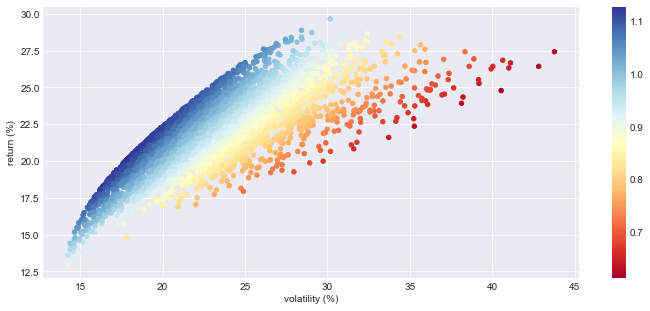

In [109]:
# create scatter plot coloured by sharpe ratio 
fig = plt.figure(figsize=(12,5))
plt.scatter(portfolios["volatility"]*100, portfolios["return"]*100, c=portfolios["sharpe ratio"], s=20, edgecolor=None, cmap='RdYlBu')
plt.xlabel("volatility (%)")
plt.ylabel("return (%)")
plt.colorbar()
plt.grid()

We can see, for example, that if the investor is targeting **a return of $20\%$**, this can be achieved by holding 
a portfolio **with volatility of about $18\%$**, although there are many other portfolios that 
can guarantee the same return but with much higher volatilities such as $27\%$. 
It is clear that one should carefully choose the weights of the portfolio. 

We can see, in particular, that there are two *special* portfolios:

1. the **portfolio with the lowest volatility**, i.e., the minimum variance portfolio
2. the **portfolio with the highest sharpe ratio**.

From the code above we can easily locate these two portfolios in our dataframe by looking at the lowest volatility and highest sharpe ratio 
and and recover the corresponding weights that have been stored.

In [ ]:
# find the portfolio with lowest volatility 
low_vol_portfolio = portfolios.iloc[ portfolios['volatility'].idxmin() ]

# find the portfolio with highest sharpe ratio
high_sharpe_portfolio = portfolios.iloc[ portfolios['sharpe ratio'].idxmax() ]

# create scatter plot coloured by sharpe ratio 
fig = plt.figure(figsize=(12,5))
plt.scatter(portfolios["volatility"]*100, portfolios["return"]*100, c=portfolios["sharpe ratio"], s=20, edgecolor=None, cmap='RdYlBu', label=None)
plt.colorbar()

plt.scatter(low_vol_portfolio[1]*100,     low_vol_portfolio[0]*100,     color='g', s=100, label="min. volatility port.")
plt.scatter(high_sharpe_portfolio[1]*100, high_sharpe_portfolio[0]*100, color='r', s=100, label="highest sharpe port.")
plt.xlabel("volatility (%)")
plt.ylabel("return (%)")
plt.grid()

plt.legend()

print("Portfolio with lowest volatility:")
print(low_vol_portfolio)

print("Portfolio with maximum sharpe ratio:")
print(high_sharpe_portfolio)

Portfolio with lowest volatility:
return          0.128734
volatility      0.142310
sharpe ratio    0.904603
w1              0.068944
w2              0.803732
w3              0.033265
w4              0.094059
Name: 35, dtype: float64
Portfolio with maximum sharpe ratio:
return          0.202411
volatility      0.179459
sharpe ratio    1.127896
w1              0.338577
w2              0.358087
w3              0.059261
w4              0.244075
Name: 507, dtype: float64


In [125]:
low_vol_portfolio[0]

0.1287342389502189